# Plot results using the DataFrame stored in pickle file

In [88]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

### Load v1.2.4 results:

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('WinoResultsv1.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.

### Load v2.0.0 results:

In [4]:
#Merge with SModelS DataFrame
dataDFnew = pd.read_pickle('WinoResultsv2.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [5]:
#Set points without results with r == 0
dataDFnew.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDFnew = dataDFnew.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDFnew['excluded'] = dataDFnew['ExptRes.result0.r'] > 1.

#### Add c*tau column for charginos

In [6]:
dataDFnew['ctau.1000024'] = 1.967e-16/dataDFnew['width.1000024']
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Get points excluded by each version:

In [113]:
excv1 = dataDF[dataDF['excluded'] == True]
excv2 = dataDFnew[dataDFnew['excluded'] == True]
excv1only = dataDF[(dataDF['excluded'] == True ) & (dataDFnew['excluded'] == False)]
excv2only = dataDFnew[(dataDFnew['excluded'] == True) & (dataDF['excluded'] == False)]
print('Total number of points = %i' %len(dataDF))
print('Total excluded v1.2.4 = %i, v2.0 = %i'%(len(excv1),len(excv2)))
print('Total excluded only v1.2.4 = %i, only in v2.0 = %i' %(len(excv1only),len(excv2only)))

<ipython-input-113-500ff2570ec8>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  excv1only = dataDF[(dataDF['excluded'] == True ) & (dataDFnew['excluded'] == False)]
<ipython-input-113-500ff2570ec8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  excv2only = dataDFnew[(dataDFnew['excluded'] == True) & (dataDF['excluded'] == False)]


Total number of points = 43680
Total excluded v1.2.4 = 8832, v2.0 = 15474
Total excluded only v1.2.4 = 1183, only in v2.0 = 7825


#### Plot distribution excluded points

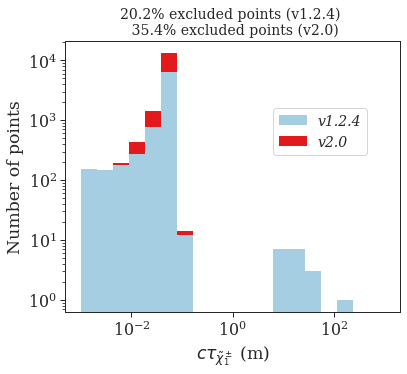

In [84]:
plt.figure(figsize=(6,5))
xExcludedv2 = excv2only['ctau.1000024']
xExcludedv1 = excv1['ctau.1000024']
nbins = np.logspace(-3,3,20)
colors = np.take(sns.color_palette("Paired"),[0,5],axis=0)
plt.hist([xExcludedv1,xExcludedv2],nbins,stacked=True, 
                            histtype='bar', label=['v1.2.4','v2.0'],
                            linewidth=0, fill=True, color=colors)
lgd = plt.legend(bbox_to_anchor=(0.62, 0.75), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size' : 14},framealpha=1.)
plt.yscale('log')
plt.xscale('log')
plt.title('%1.1f%% excluded points (v1.2.4) \n %1.1f%% excluded points (v2.0)' %(100*len(excv1)/float(len(dataDF)),
                                                                             100*len(excv2)/float(len(dataDFnew)))
                                                                      , fontsize=14)
plt.xlabel(r'$c \tau_{\tilde{\chi}_1^\pm}$ (m)')
plt.ylabel('Number of points')
plt.show()

### Plot excluded points grouped by most excluding analysis

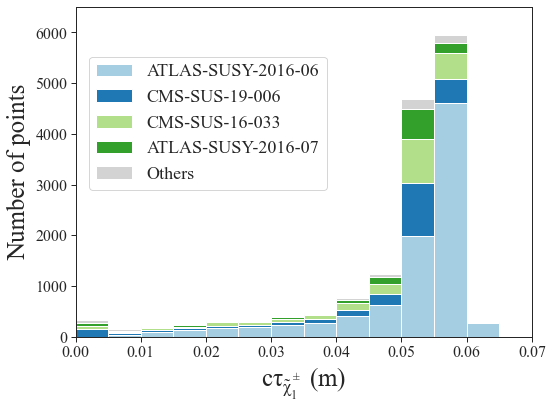

In [109]:
excluded = excv2
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)
# print(anas)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
colorDict = dict(zip(anas.index,sns.color_palette("Paired",len(anas))))
c_other = 'lightgray'
first = True
labels= []
hists = []
colors = []
xothers = []
for i,ana in enumerate(anas.index):
    x = excv2[excv2['ExptRes.result0.AnalysisID'] == ana]['ctau.1000024']
    if anas[ana] < 1000:
        xothers += x.tolist()        
        continue
    else:
        color = colorDict[ana]
        label = ana
    
    hists.append(x)
    colors.append(color)
    labels.append(label)

hists.append(xothers)
labels.append('Others')
colors.append(c_other)
plt.hist(hists,nbins,color=colors,label=labels,
                            histtype='barstacked',
                            linewidth=1, fill=True)

lgd = plt.legend(bbox_to_anchor=(0.03, 0.85), loc=2, borderaxespad=0.,framealpha=1.,fontsize=18)

plt.ylim(0,6500)
plt.xlim(0,0.07)
# plt.title('SModelS v2.0', fontsize=26)
plt.xlabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.ylabel('Number of points',fontsize = 25)
plt.tight_layout()
plt.savefig('Wino_v2.png')
plt.show()

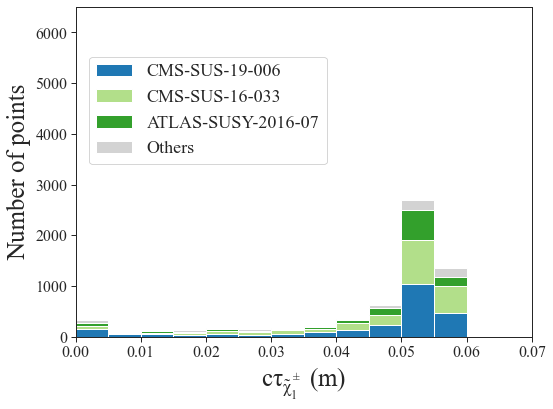

In [108]:
excluded = excv1
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(8,6))

# nbins = np.logspace(-3,3,20)
nbins=np.linspace(0,0.07,15)
c_other = 'lightgray'
first = True
labels= []
hists = []
colors = []
xothers = []
for ana in anas.index:
    x = excv2[excv2['ExptRes.result0.AnalysisID'] == ana]['ctau.1000024']
    if anas[ana] < 1000:
        xothers += x.tolist()        
        continue
    else:
        color = colorDict[ana]
        label = ana
    
    hists.append(x)
    colors.append(color)
    labels.append(label)

hists.append(xothers)
labels.append('Others')
colors.append(c_other)
plt.hist(hists,nbins,color=colors,label=labels,
                            histtype='barstacked',
                            linewidth=1, fill=True)

lgd = plt.legend(bbox_to_anchor=(0.03, 0.85), loc=2, borderaxespad=0.,framealpha=1.,fontsize=18)

plt.ylim(0,6500)
plt.xlim(0,0.07)
# plt.title('SModelS v1.2.4', fontsize=26)
plt.xlabel(r'$\mathregular{c \tau_{\tilde{\chi}_1^\pm}}$ (m)',fontsize = 25)
plt.ylabel('Number of points',fontsize = 25)
plt.tight_layout()
plt.savefig('Wino_v1.png')
plt.show()